###### ECE 283: Homework 3
###### Topics: Unsupervised Learning, part 1 (Gaussian mixtures and EM algorithm; K-means and soft K-means)
###### Due: Friday May 11

- Neural networks; Tensorflow
- 2D synthetic gaussian mixture data for binary classification

### Report

----------------------------------------

##### 1.Generate the 2D sample data





# Code Section

In [343]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
from IPython.display import Image, display, Math, Latex

# Params
n_inpoints = 200

In [344]:
def generateClass0(): 
    theta0 = 0
    lmb01 = 2
    lmb02 = 1
    m0 = (0,  0)
    # computing u * u.T and later multiplying with lambda
    cov01 = [[(cos(theta0))**2,    cos(theta0)*sin(theta0)],
             [(sin(theta0))*cos(theta0), (sin(theta0))**2]]
    cov02 = [[(sin(theta0))**2,    -(cos(theta0)*sin(theta0))],
             [-(cos(theta0)*sin(theta0)), (cos(theta0))**2]]
    cov0 = lmb01*np.matrix(cov01) + lmb02*np.matrix(cov02)
    print('Mean: ',m0,' ','\nCov :',cov0)
    cov0_det = np.linalg.det(cov0)
    x0, y0 = np.random.multivariate_normal(m0, cov0, int(n_inpoints)).T
    return x0,y0

x0, y0 = generateClass0()

Mean:  (0, 0)   
Cov : [[2. 0.]
 [0. 1.]]


In [345]:
# Mixture A
def generateClass1a():
    theta1a = -3*pi/4
    lmb1a1 = 2
    lmb1a2 = 1/4
    m1a = (-2, 1)
    cov1a = [[(cos(theta1a))**2,    cos(theta1a)*sin(theta1a)],
             [(sin(theta1a))*cos(theta1a), (sin(theta1a))**2]]
    cov2a = [[(sin(theta1a))**2,    -(cos(theta1a)*sin(theta1a))],
             [-(cos(theta1a)*sin(theta1a)), (cos(theta1a))**2]]
    cov1a = lmb1a1*np.matrix(cov1a) + lmb1a2*np.matrix(cov2a)
    cov1a_det = np.linalg.det(cov1a)
    x1a, y1a = np.random.multivariate_normal(m1a, cov1a, int(n_inpoints)).T
    print('Mean: ',m1a,' ','\nCov :',cov1a)
    return x1a,y1a

# Mixture B
def generateClass1b():
    theta1b = pi/4
    lmb1b1 = 3
    lmb1b2 = 1
    m1b = (3, 2)
    cov1b = [[(cos(theta1b))**2,    cos(theta1b)*sin(theta1b)],
             [(sin(theta1b))*cos(theta1b), (sin(theta1b))**2]]
    cov2b = [[(sin(theta1b))**2,    -(cos(theta1b)*sin(theta1b))],
             [-(cos(theta1b)*sin(theta1b)), (cos(theta1b))**2]]
    cov1b = lmb1b1*np.matrix(cov1b) + lmb1b2*np.matrix(cov2b)
    cov1b_det = np.linalg.det(cov1b)
    x1b, y1b = np.random.multivariate_normal(m1b, cov1b, int(n_inpoints)).T
    print('Mean: ',m1b,' ','\nCov :',cov1b)
    return x1b,y1b

x1a, y1a = generateClass1a()
x1b, y1b = generateClass1b()

Mean:  (-2, 1)   
Cov : [[1.125 0.875]
 [0.875 1.125]]
Mean:  (3, 2)   
Cov : [[2. 1.]
 [1. 2.]]


Coefficients count for 3 GMM components:  [100, 33, 67]
Component identifiers for GMM mixture:  (200, 1)


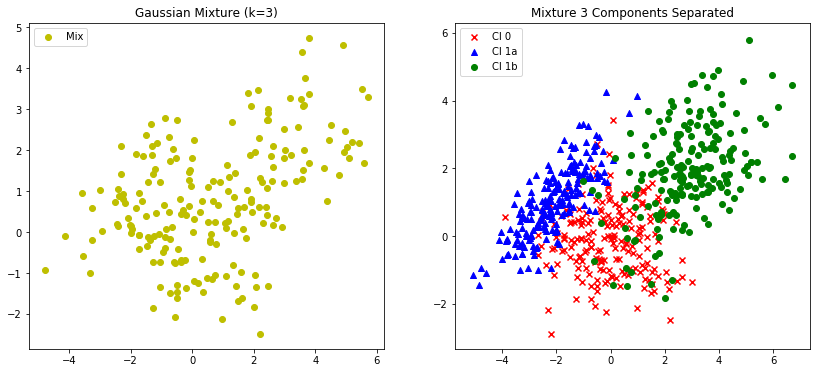

In [346]:
# Mixture Density of 3 component Gaussian
# [Class0 * (1/2) + Class1A * (1/6) + Class1B * (1/3)] 
cnt_m1 = [int(ceil(n_inpoints*(1/2))),int(floor(n_inpoints*(1/6))),int(ceil(n_inpoints*(1/3)))] 
print('Coefficients count for 3 GMM components: ',cnt_m1)

# Randomly pick mixture components 
idx_m1 = np.argsort(np.random.random(n_inpoints))[:cnt_m1[0]]
idx_m2 = np.argsort(np.random.random(n_inpoints))[:cnt_m1[1]]
idx_m3 = np.argsort(np.random.random(n_inpoints))[:cnt_m1[2]]

# Combine the arrays 

y = np.concatenate((np.array(y0[idx_m1]), np.array(y1a[idx_m2]), np.array(y1b[idx_m3])), axis = 0)
x = np.concatenate((np.array(x0[idx_m1]), np.array(x1a[idx_m2]), np.array(x1b[idx_m3])), axis = 0)
z = np.array([1,0,0]*int(cnt_m1[0]) + [0,1,0]*int(cnt_m1[1])+ [0,0,1]*int(cnt_m1[2])).reshape(n_inpoints,3)
z_val = np.array([0]*int(cnt_m1[0]) + [1]*int(cnt_m1[1])+ [2]*int(cnt_m1[2])).reshape(n_inpoints,1)
print('Component identifiers for GMM mixture: ', z_val.shape)

# Subplots 
f, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.scatter(x, y, color = 'y',marker='o', label = 'Mix')
ax1.set_title('Gaussian Mixture (k=3)')
ax1.legend()
ax2.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
ax2.scatter(x1a, y1a, color = 'b',marker='^', label = 'Cl 1a')
ax2.scatter(x1b, y1b, color = 'g',marker='o', label = 'Cl 1b')
ax2.set_title('Mixture 3 Components Separated')
ax2.legend()
f.subplots_adjust()

Training Data, X(x1,x2) Shape: (200, 2) , Y Shape (200, 1)


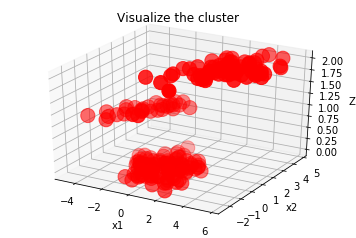

In [347]:
# ----------------------------------------
# Set up the [Xi, Yi] training data vector
# ----------------------------------------
X = np.vstack((x, y)).T
Z_val = z_val
print("Training Data, X(x1,x2) Shape:",X.shape, ', Y Shape', z_val.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Z_val, s=int(z_val.shape[0]), c='r', marker='o')
ax.set_title('Visualize the cluster')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Z')
plt.show()

## 1. KMEANS

##### With values of K = 2, 3, 4, 5. For each K, start with several different random initializations, 
##### and choose the run that leads to the smallest mean squared error. 


In [348]:
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=2)  
kmeans.fit(X)  
print(kmeans.cluster_centers_) 
# plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')  
#plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  

[[-0.70897911  0.17260303]
 [ 3.00013188  1.83209644]]


K= 2
(K= 1 )Prob:( 7 / 67 )= 0.1044776119402985
(K= 2 )Prob:( 33 / 133 )= 0.24812030075187969
K= 3
(K= 1 )Prob:( 46 / 63 )= 0.7301587301587301
(K= 2 )Prob:( 0 / 49 )= 0.0
(K= 3 )Prob:( 1 / 88 )= 0.011363636363636364
K= 4
(K= 1 )Prob:( 38 / 56 )= 0.6785714285714286
(K= 2 )Prob:( 0 / 62 )= 0.0
(K= 3 )Prob:( 49 / 49 )= 1.0
(K= 4 )Prob:( 0 / 33 )= 0.0
K= 5
(K= 1 )Prob:( 0 / 45 )= 0.0
(K= 2 )Prob:( 0 / 41 )= 0.0
(K= 3 )Prob:( 19 / 49 )= 0.3877551020408163
(K= 4 )Prob:( 0 / 16 )= 0.0
(K= 5 )Prob:( 0 / 49 )= 0.0


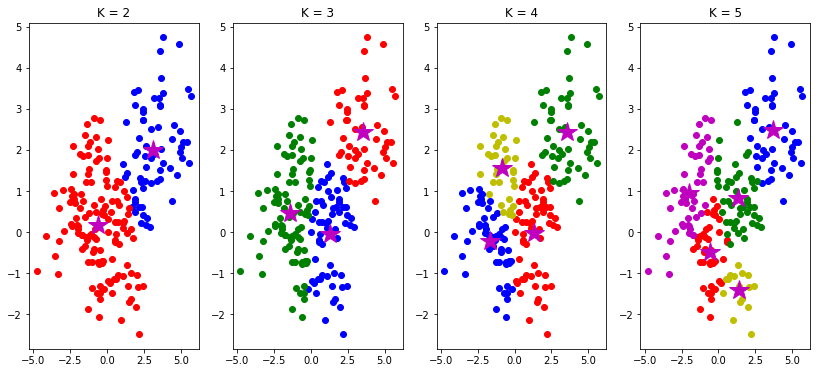

In [349]:
# KMeans Algorithms Implementation using euclidean distance 
def kMeans(X, K, maxIters = 10):
    # Centroid m1, m2 ... mk
    centroids = X[np.random.choice(np.arange(len(X)), K), :]
    #print(centroids)
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([np.dot(x_i-m_k, x_i-m_k) for m_k in centroids]) for x_i in X])
        # Move centroids step
        centroids = [X[C == k].mean(axis = 0) for k in range(K)]
    return np.array(centroids) , C


# Calculate the probability wrt the ground truth
def cprob(C, K): 
    ground = (Z_val.T)[0]
    print('K=',K)
    for k in range(K):
        found_ids = np.where(C==k)
        matched_ground = np.count_nonzero(C[found_ids]==ground[found_ids])
        if(len(found_ids[0])>0):
            print('(K=',k+1,')Prob:(',matched_ground,'/',len(found_ids[0]),')=', (matched_ground/len(found_ids[0])))
        else:
            print('(K=',k+1,')Prob:(',matched_ground,'/',len(found_ids[0]),')=', 0)
        
   
    
# Provide a value of k = (1,...K) and plot the centroids
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(14,6))
centroids, C = kMeans(X, K = 2)
ax1.plot(X[C == 0, 0], X[C == 0, 1], 'ob',
             X[C == 1, 0], X[C == 1, 1], 'or')
ax1.plot(centroids[:,0],centroids[:,1],'*m',markersize=20)
ax1.set_title('K = 2')
cprob(C,2)

centroids, C = kMeans(X, K = 3)
ax2.plot(X[C == 0, 0], X[C == 0, 1], 'ob',
             X[C == 1, 0], X[C == 1, 1], 'or',
             X[C == 2, 0], X[C == 2, 1], 'og')
ax2.plot(centroids[:,0],centroids[:,1],'*m',markersize=20)
ax2.set_title('K = 3')
cprob(C,3)

centroids, C = kMeans(X, K = 4)
ax3.plot(X[C == 0, 0], X[C == 0, 1], 'ob',
             X[C == 1, 0], X[C == 1, 1], 'or',
             X[C == 2, 0], X[C == 2, 1], 'og',
             X[C == 3, 0], X[C == 3, 1], 'oy')
ax3.plot(centroids[:,0],centroids[:,1],'*m',markersize=20)
ax3.set_title('K = 4')
cprob(C,4)
centroids, C = kMeans(X, K = 5)
ax4.plot(X[C == 0, 0], X[C == 0, 1], 'ob',
             X[C == 1, 0], X[C == 1, 1], 'or',
             X[C == 2, 0], X[C == 2, 1], 'og',
             X[C == 3, 0], X[C == 3, 1], 'oy',
             X[C == 4, 0], X[C == 4, 1], 'om')
ax4.plot(centroids[:,0],centroids[:,1],'*m',markersize=20)
ax4.set_title('K = 5')
cprob(C,5)

## 2. KMEANS - EM Algorithm

#### E-STEP
We will evaluate the expectation of the below equation for the current estimate of the parameter,

- $ log p(x_{i}, z_{i} | \theta) = \sum_{k=1}^{K} z_{i} [k] (log N (x_{i} | m_{k}, C_{k}) + log \pi_{k})$
- $ E[log p(x_{i}, z_{i} | \theta) | \theta^l ] = \sum_{k=1}^{K} p(k|x_{i}) (log N (x_{i} | m_{k}, C_{k}) + log \pi_{k})$

Note that $ \theta = \{ pi_{k}, m_{k}, C_{k} \}_{k=1}^{K} $ in the above is to be optimized over to get the next estimate $ \theta^{l+1} $ in the M-step, and $ p(k|x_{i}) $ are numerical values that we computed using the current estimate
$ \theta^{l} $  in the E-step

#### M-STEP
We now use these assignment probabilities as weights as to how much each data point counts towards estimating the parameters for a given cluster, and update the parameters for each component k as follows,

- $ m_{k} = \frac{ \sum_{i=1}^{N} p(k|x_{i})x_{i}}{\sum_{i=1}^{N} p(k|x_{i})} $
- $ C_{k} = \frac{ \sum_{i=1}^{N} p(k|x_{i})(x_{i} - m_{k})(x_{i} - m_{k})^{T}}{\sum_{i=1}^{N} p(k|x_{i})} $
- $ pi_{k} = \frac{ \sum_{i=1}^{N} p(k|x_{i})}{N} $




---------- K= 2 Parameters estimate ----------
LogL : [-1443.8712127929475, -2.6645352591003757e-15, -4.440892098500626e-16]
Mu   : [[ 1.89664019  0.91554641]
 [-1.26597984 -0.73207991]]
Si   : [array([[3.19685129, 1.65836958],
       [1.65836958, 2.47686373]]), array([[1., 0.],
       [0., 1.]])]
W    : [0.599626914218638, 0.5]

---------- K= 3 Parameters estimate ----------
LogL : [-1548.9254985339412, -46.62687442378522, -2.1094237467877974e-15, -1.1102230246251565e-16]
Mu   : [[-0.86351342  0.08769299]
 [-2.59274042  0.4572016 ]
 [-1.19470582  0.4705352 ]]
Si   : [array([[ 1.80255215, -0.20035322],
       [-0.20035322,  1.23006732]]), array([[1.16039848, 0.45399151],
       [0.45399151, 0.83196014]]), array([[1., 0.],
       [0., 1.]])]
W    : [0.19658655041247083, 0.07158112588536046, 0.3333333333333333]

---------- K= 4 Parameters estimate ----------
LogL : [-975.9765873525405, -234.42607708187424, -1.5543122344752194e-15, -6.661338147750939e-16]
Mu   : [[ 1.80463829  0.17809589

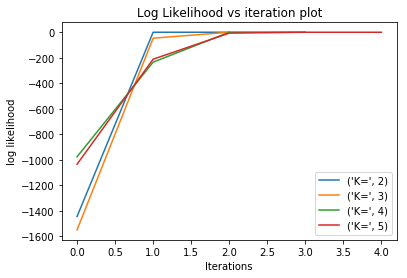

In [350]:

def fit_EM(X, max_iters = 1000, k=2, eps=0.000001):
    # n = number of data-points, d = dimension of data points        
    n, d = X.shape
    # randomly choose the starting centroids/means as 3 of the points from datasets        
    mu = X[np.random.choice(n, k, False), :]
    # initialize the covariance matrices for each gaussians``````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
    Sigma= [np.eye(d)] * k
    # initialize the probabilities/weights for each gaussians
    w = [1./k] * k
    # responsibility matrix is initialized to all zeros
    # we have responsibility for each of n points for eack of k gaussians
    R = np.zeros((n, k))
    
    ### log_likelihoods
    log_likelihoods = []
    P = lambda mu, s: (np.linalg.det(s)** -.5)*((2*np.pi)**(-X.shape[1]/2.)) \
            * np.exp(-.5 * np.einsum('ij, ij -> i',X - mu, \
                np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
    
    # Iterate till max_iters iterations        
    while len(log_likelihoods) < max_iters:

        # E - Step
        ## Vectorized implementation of e-step equation to calculate the 
        ## membership for each of k -gaussians
        for k in range(k):
            R[:, k] = w[k] * P(mu[k], Sigma[k])
        ### Likelihood computation
        log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
        log_likelihoods.append(log_likelihood)
        ## Normalize so that the responsibility matrix is row stochastic
        R = (R.T / np.sum(R, axis = 1)).T
        ## The number of datapoints belonging to each gaussian            
        N_ks = np.sum(R, axis = 0)

        # M Step
        ## calculate the new mean and covariance for each gaussian by 
        ## utilizing the new responsibilities
        for k in range(k):
            ## means
            mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
            x_mu = np.matrix(X - mu[k])
            ## covariances
            Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
            ## and finally the probabilities
            w[k] = 1. / n * N_ks[k]
        # check for onvergence
        if len(log_likelihoods) < 2 : continue
        if np.abs(log_likelihood - log_likelihoods[-2]) < eps: break
    
    ## bind all results together
    from collections import namedtuple
    params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
    params.mu = mu
    params.Sigma = Sigma
    params.w = w
    params.log_likelihoods = log_likelihoods
    params.num_iters = len(log_likelihoods)   
    return params

for k_trial in [2,3,4,5]:
    print('\n---------- K=',k_trial,'Parameters estimate ----------')
    params = fit_EM(X, max_iters= 100, k= k_trial)
    print('LogL :',params.log_likelihoods)
    print('Mu   :',params.mu)
    print('Si   :',params.Sigma)
    print('W    :',params.w)
    lbl = 'K=',k_trial
    plt.plot(params.log_likelihoods, label=lbl)

plt.title('Log Likelihood vs iteration plot')
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.legend()
plt.show()

### 3) Comment (using 2D plots) on how the means and covariances of the mixture components you find relate geometrically to the \ground truth" mixture components for different values of K.

In [351]:
# Create a chart for this

##### Experiments with data in higher dimensions
Let us now see what happens when we increase the number of dimensions to d (d to be played
with, but the nominal value is d = 30), while keeping the \effective dimension" (I’m not defining
this formally, but you should soon see what I mean once I tell you how to generate the data)
smaller than d.


### 4) Program to generate a random vector u in d dimensions as follows:
The components of u are i.i.d., with
P[u[i] = 0] = 2=3; P[u[i] = +1] = 1=6; P[u[i] = −1] = 1=6

Let {uj; j = 1 . . . .  7} be i.i.d.

In [394]:
d = 30
ul = 7


def checkCorrelation(uj1, uj2):
    udot = np.dot(uj1, uj2)
    return udot

# Generate the IID 
def generateMultiDimGaussian():
    uj_cnts = [int(ceil(d*(2/3))),int(floor(d*(1/6))),int(ceil(d*(1/6)))]
    uj_vals = np.array([0]*int(uj_cnts[0]) + [1]*int(uj_cnts[1])+ [-1]*int(uj_cnts[2]))
    print('Number of Data points: ',uj_cnts)
    u = np.zeros([ul,d])
    np.random.shuffle(uj_vals)
    u[0] = uj_vals
    for j in np.arange(1, ul):
        #print('Prev: ', u[j-1])
        np.random.shuffle(uj_vals)      # Shuffled
        u[j] = uj_vals
        #print('Curr: ', u[j])
        corr = checkCorrelation(u[j-1],u[j])
        #if too correlated then use another
        if(corr*2 > 1):
            np.random.shuffle(uj_vals)      # Shuffled again
        print(j,' Corr => ',corr)
    return u

# Uj be i.i.d
uj = generateMultiDimGaussian()
print(uj.shape)

Number of Data points:  [20, 5, 5]
1  Corr =>  1.0
2  Corr =>  -1.0
3  Corr =>  1.0
4  Corr =>  2.0
5  Corr =>  3.0
6  Corr =>  0.0
(7, 30)


### 5) Generate d-dimensional data samples for a Gaussian mixture distribution with 3 equiprobable components
- Zm  : Standard Gaussian (N(0, 1)) distribution
- N   : noise vector" N ∼ N(0, σ2Id) (default value σ2 = 0:01)
- Component 1: Generate X = u1 + Z1u2 + Z2u3 + N.
- Component 2: Generate X = 2u4 + sqrt(2)Z1u5 + Z2u6 + N.
- Component 3: Generate X = sqrt(2)u6 + Z1(u1 + u2) + (1/sqrt(2))Z2u5 + N

In [433]:
num_data = 300
Zm = [np.random.normal(0,1,num_data), np.random.normal(0,1,num_data)]
N_cov = np.eye(d) * (0.01)
N_mu = np.zeros([1,d])[0]

print('Zm:',Zm[0].shape,', N:',N.shape)
print('Uj:',uj[0].shape)
# Function for each component function
Xm1 = lambda z1, z2, n: (u[0].reshape(d,1) + z1*u[1].reshape(d,1) + z2*u[2].reshape(d,1) + n)
Xm2 = lambda z1, z2, n: (2*u[3].reshape(d,1) + 1.414 * z1*u[4].reshape(d,1) + z2*u[5].reshape(d,1) + n)
Xm3 = lambda z1, z2, n: (1.414*u[5].reshape(d,1) + z1*(u[0].reshape(d,1)+u[1].reshape(d,1)) + (1/1.414)*z2*u[4].reshape(d,1) + n)
X = np.zeros([num_data, d])

# Assign the values based on the three component function
for i in range(0, num_data, 3):
    N = np.random.multivariate_normal(N_mu, N_cov, 1)  
    X[i+0] = Xm1(Zm[0][i], Zm[1][i], N.T).T
    X[i+1] = Xm2(Zm[0][i], Zm[1][i], N.T).T
    X[i+2] = Xm3(Zm[0][i], Zm[1][i], N.T).T
    # print(i)

print(X.shape)

Zm: (300,) , N: (1, 30)
Uj: (30,)
(300, 30)


### 6) Generate N =?? (to be determined) data samples from the preceding model, saving both the data point xi and zi 2 f0; 1g3, the one-hot encoding of which component the data point belongs to. Implement the K-means algorithm with different values of K = 2; 3; 4; 5.

### Results